## Задача регресси

#### Содержание:
- <a href="#простая-линейная-регрессия">Перейти к введению</a>
- [Множественная линейная регрессия](#множественная-линейная-регрессия)

#### Необходимые функции

In [903]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, adjusted_rand_score
from math import sqrt
import optuna
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

def print_error(Y_test, Y_pred, custom = False):
    MAE = round(mean_absolute_error(Y_test, Y_pred) if custom else np.mean(np.abs(Y_test-Y_pred)), 5)
    MSE = round(mean_squared_error(Y_test, Y_pred) if custom else np.mean((Y_test-Y_pred)**2),5)
    RMSE = round(sqrt(mean_squared_error(Y_test, Y_pred)) if custom else np.sqrt(MSE),5)
    MAPE = round(sqrt(mean_absolute_percentage_error(Y_test, Y_pred)) if custom else np.mean(np.abs((Y_test-Y_pred)/(Y_test))),5)
    Adjusted_rand = round(adjusted_rand_score(Y_test, Y_pred),5)
    R2 = round(r2_score(Y_test, Y_pred) if custom else 1-(MSE/(np.mean((Y_test-np.mean(Y_test))**2))),5)
    print(pd.DataFrame([MAE, MSE, RMSE, MAPE, Adjusted_rand, R2], index = ['MAE', 'MSE', 'RMSE', 'MAPE', 'Adjusted_rand', 'R^2'], columns=['Метрики качества']));




In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np

def formated_params(items):
    formatted_params = []
    output = ""
    for key, value in items.items():
        formatted_params.append(f"'{key}':{round(float(value),3)}")
    output += ", ".join(formatted_params)
    return output

def gridSearchCV_params(model, parameters,X_train, Y_train):
    optimal = GridSearchCV(model, parameters).fit(X_train, Y_train)
    output = formated_params(optimal.best_params_)
    print(f" Лучшие параметры для модели (GridSearchCV) {output}")

def randomizedSearchCV_params(model, parameters, X_train, Y_train):
    optimal = RandomizedSearchCV(model, parameters).fit(X_train, Y_train)
    output = formated_params(optimal.best_params_)
    print(f"Лучшие параметры для модели (RandomizedSearchCV) {output}")

optuna.logging.set_verbosity(optuna.logging.WARNING)

def optuna_params(objective):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)
    best_params = study.best_params
    return best_params



In [905]:
def print_chart(name, Y_test, Y_pred):
    plt.figure(figsize=(6,4))
    plt.title(name)
    sns.distplot(Y_test, hist=False, color='Red', label='Actual values')
    sns.distplot(Y_pred, hist=False, color='Green', label='Predicted values')
    plt.legend()
    plt.show();

### 1. Загрузка данных 

- **Целевой признак:** ```price``` - модель регрессии будет обучена наиболее точно оценивать стоимость жилья в Мумбаи на основе предикторов

- **Предикторы:** 

    1. ```area``` - площадь дома _(int16)_ 
    2. ```latitude, longitude``` - географические координаты _(float64)_
    3. ```bedrooms, balcony, balcony``` - количество спальнь, балконов, ванных комнат _(uint8)_ 
    4. ```lift, parking``` - количество лифтов, парковок _(uint8)_

In [906]:
import pandas as pd

In [907]:
data = pd.read_csv('result_mumbai.csv')
data

,price,area,latitude,longitude,bedrooms,bathrooms,balcony,ready_to_move,new_housing,parking,lift,flat_or_individual,furnished_status_Semi-Furnished,furnished_status_Unfurnished
0,22.4,629,19.032800,72.896357,2,2,0,0,1,0,0,1,0,1
1,35.0,974,19.032800,72.896357,3,2,0,0,1,0,0,1,0,1
2,31.7,968,19.085600,72.909277,3,3,0,0,1,0,0,1,0,1
3,18.7,629,19.155756,72.846862,2,2,2,1,1,2,2,1,0,1
4,13.5,1090,19.177555,72.849887,2,2,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6232,19.5,810,19.138320,72.810020,2,2,0,1,0,0,0,1,1,0
6233,22.0,1400,19.221920,72.854250,3,3,1,1,0,1,1,1,0,1
6234,20.0,750,19.144320,72.824111,2,2,0,1,0,0,0,1,0,1
6235,11.0,700,19.047201,72.872225,2,2,0,1,0,0,0,1,0,0


#### Тест Пирсона

In [908]:
from scipy import stats

In [909]:
col_list = data.columns.to_list()[1:]
Y = data['price']
for x_pearson in col_list:
  pearson_coef, p_value = stats.pearsonr(data[x_pearson], Y)
  print(x_pearson)
  print('Коэффициент корреляции Пирсона = ', pearson_coef, ' P-значение = ', p_value)
  print('')

area
Коэффициент корреляции Пирсона =  0.7124627926066616  P-значение =  0.0

latitude
Коэффициент корреляции Пирсона =  -0.43919194218649826  P-значение =  1.679089892065569e-292

longitude
Коэффициент корреляции Пирсона =  -0.18269665282474487  P-значение =  6.003046375705695e-48

bedrooms
Коэффициент корреляции Пирсона =  0.5865678572934709  P-значение =  0.0

bathrooms
Коэффициент корреляции Пирсона =  0.6393695821809986  P-значение =  0.0

balcony
Коэффициент корреляции Пирсона =  0.09471192036259504  P-значение =  6.619867065387366e-14

ready_to_move
Коэффициент корреляции Пирсона =  -0.0022298047688954553  P-значение =  0.8602444174914269

new_housing
Коэффициент корреляции Пирсона =  0.03745686685423266  P-значение =  0.003090506693618342

parking
Коэффициент корреляции Пирсона =  0.09471192036259504  P-значение =  6.619867065387366e-14

lift
Коэффициент корреляции Пирсона =  0.09471192036259504  P-значение =  6.619867065387366e-14

flat_or_individual
Коэффициент корреляции Пир

Незначимые признаки:

- ```ready_to_move```
- ```flat_or_individual```

In [910]:
data.drop(['flat_or_individual', 'ready_to_move'], axis=1, inplace = True)

#### Шаг 1: Выделим целевой признак и предикторы

In [911]:
Y = data['price']
X = data.drop(['price'], axis =1)
Y

0       22.4
1       35.0
2       31.7
3       18.7
4       13.5
        ... 
6232    19.5
6233    22.0
6234    20.0
6235    11.0
6236    15.0
Name: price, Length: 6237, dtype: float64

In [912]:
X

,area,latitude,longitude,bedrooms,bathrooms,balcony,new_housing,parking,lift,furnished_status_Semi-Furnished,furnished_status_Unfurnished
0,629,19.032800,72.896357,2,2,0,1,0,0,0,1
1,974,19.032800,72.896357,3,2,0,1,0,0,0,1
2,968,19.085600,72.909277,3,3,0,1,0,0,0,1
3,629,19.155756,72.846862,2,2,2,1,2,2,0,1
4,1090,19.177555,72.849887,2,2,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
6232,810,19.138320,72.810020,2,2,0,0,0,0,1,0
6233,1400,19.221920,72.854250,3,3,1,0,1,1,0,1
6234,750,19.144320,72.824111,2,2,0,0,0,0,0,1
6235,700,19.047201,72.872225,2,2,0,0,0,0,0,0


#### Шаг 2: разделим данные на обучающую и тестовую выборки

Воспользуемся библиотекой Sklearn

In [913]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [914]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4989, 11), (4989,), (1248, 11), (1248,))

### 2 Решение задач регрессии

In [915]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

####  <span style = "color:#FFA500">Простая линейная регрессия   </span> <a name = "простая-линейная-регрессия"></a>

Учитывая тест Пирсона, лучшая переменная для обучения простой линейной регрессии - ```area```

In [916]:
X_simple = data[['area']]
Y_simple = Y

In [917]:
X_train_simple, X_test_simple, Y_train_simple, Y_test_simple = train_test_split(X_simple,Y_simple,test_size=0.2)

In [918]:
lr_simple = LinearRegression().fit(X_train_simple, Y_train_simple)
Y_pred = lr_simple.predict(X_test_simple)

##### Метрики модели

In [919]:
print_error(Y_test_simple, Y_pred)

               Метрики качества
MAE                    11.09105
MSE                   332.33101
RMSE                   18.22995
MAPE                    0.66642
Adjusted_rand           0.00321
R^2                     0.50669


In [920]:
print_error(Y_test_simple,Y_pred, custom=True)

               Метрики качества
MAE                    11.09105
MSE                   332.33101
RMSE                   18.22995
MAPE                    0.81634
Adjusted_rand           0.00321
R^2                     0.50669


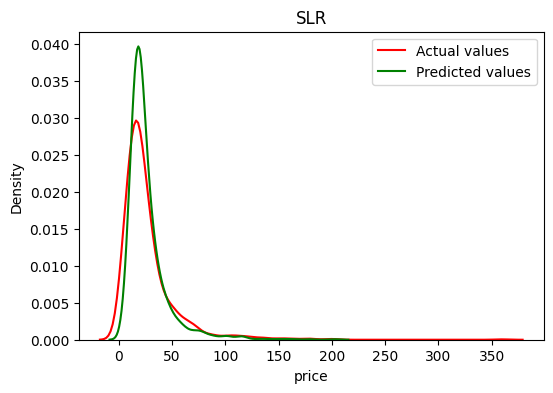

In [921]:
print_chart("SLR", Y_test, Y_pred)

#### <span style = "color: #48B0AB">Множественная линейная регрессия

In [922]:
lr = LinearRegression().fit(X_train, Y_train)
Y_pred = lr.predict(X_test)

##### Метрики модели

In [923]:
print_error(Y_test, Y_pred)

               Метрики качества
MAE                     8.89098
MSE                   222.36203
RMSE                   14.91181
MAPE                    0.50368
Adjusted_rand          -0.00002
R^2                     0.68469


In [924]:
lr.coef_

array([ 2.20158543e-02, -8.31154756e+01, -7.61824878e+01,  6.46872502e-01,
        7.51054203e+00, -7.34717903e-02,  6.83435538e-01, -7.34717903e-02,
       -7.34717903e-02, -2.70410184e+00, -2.94788884e+00])

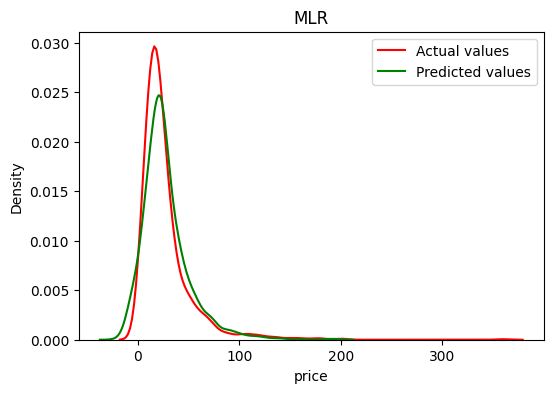

In [925]:
print_chart("MLR", Y_test, Y_pred)

#### <span style = "color: #C4BBF3"> Линейная регрессия с L1-регуляризацией

- L1/Lasso

In [926]:
lasso = Lasso(alpha=0.5).fit(X_train, Y_train)
Y_pred = lasso.predict(X_test)

In [927]:
lasso.coef_

array([ 2.43663831e-02, -3.81487242e+01, -0.00000000e+00,  0.00000000e+00,
        7.51889592e+00, -6.11484412e-01,  0.00000000e+00, -1.60917348e-15,
       -1.07278232e-16, -0.00000000e+00, -0.00000000e+00])

##### Метрики модели с L1-регуляризацией

In [928]:
print_error(Y_test, Y_pred)

               Метрики качества
MAE                     9.23555
MSE                   251.97652
RMSE                   15.87377
MAPE                    0.45675
Adjusted_rand          -0.00004
R^2                     0.64270


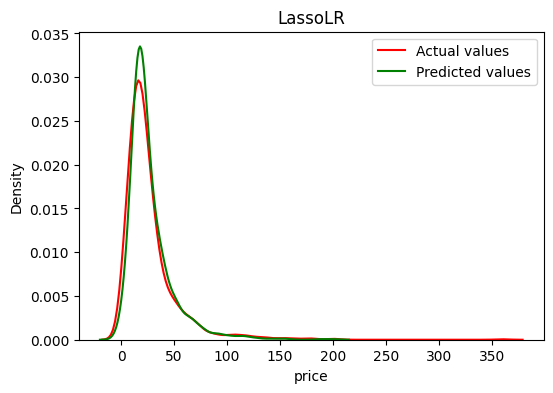

In [929]:
print_chart("LassoLR", Y_test, Y_pred)

##### Подбор оптимальных параметров

In [930]:
parameters = {'alpha': np.arange(0.01,1,0.1)}
model = Lasso()
gridSearchCV_params(model, parameters, X_train,Y_train)
randomizedSearchCV_params(model, parameters, X_train, Y_train)

 Лучшие параметры для модели (GridSearchCV) 'alpha':0.01
Лучшие параметры для модели (RandomizedSearchCV) 'alpha':0.01


In [931]:
lasso = Lasso(alpha=0.01).fit(X_train, Y_train)
Y_pred = lasso.predict(X_test)

print_error(Y_test,Y_pred)

               Метрики качества
MAE                     8.85333
MSE                   221.97417
RMSE                   14.89880
MAPE                    0.49785
Adjusted_rand          -0.00002
R^2                     0.68524


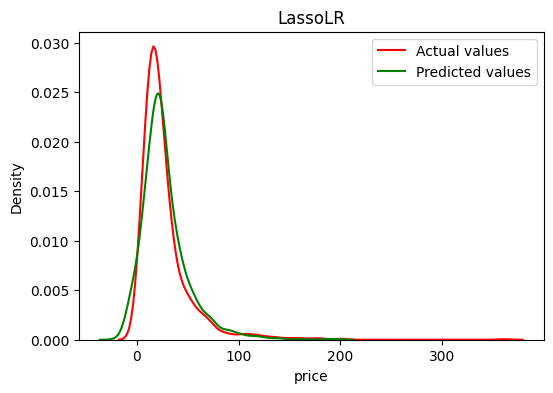

In [932]:
print_chart("LassoLR", Y_test, Y_pred)

In [933]:
def objective(trial):
    # Определяем гиперпараметры
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    model = Lasso(alpha=alpha)

    # Обучаем модель
    model.fit(X_train, Y_train)

    # Предсказываем
    y_pred = model.predict(X_test)

    # Вычисляем ошибки
    mse = mean_squared_error(Y_test, y_pred)
    return mse 

In [934]:
best_params = optuna_params(objective)
best_model = Lasso(alpha=best_params['alpha'])
best_model.fit(X_train,Y_train)
Y_pred = best_model.predict(X_test)

print_error(Y_test,Y_pred)

               Метрики качества
MAE                     8.73282
MSE                   221.28142
RMSE                   14.87553
MAPE                    0.47636
Adjusted_rand          -0.00002
R^2                     0.68622


#### <span style= "color: #F0F3BB">Линейная регрессия с L2-регуляризацией

- L2/Ridge

In [935]:
ridge = Ridge(alpha=0.5).fit(X_train,Y_train)
Y_pred = ridge.predict(X_test)

In [936]:
ridge.coef_

array([ 2.20386326e-02, -8.23036087e+01, -7.39282960e+01,  6.33951563e-01,
        7.54114241e+00, -7.73712125e-02,  6.82842012e-01, -7.73712125e-02,
       -7.73712125e-02, -2.73597105e+00, -2.97564394e+00])

##### Метрики модели с L2-регуляризацией

In [937]:
print_error(Y_test, Y_pred)

               Метрики качества
MAE                     8.86515
MSE                   222.13792
RMSE                   14.90429
MAPE                    0.49919
Adjusted_rand          -0.00002
R^2                     0.68501


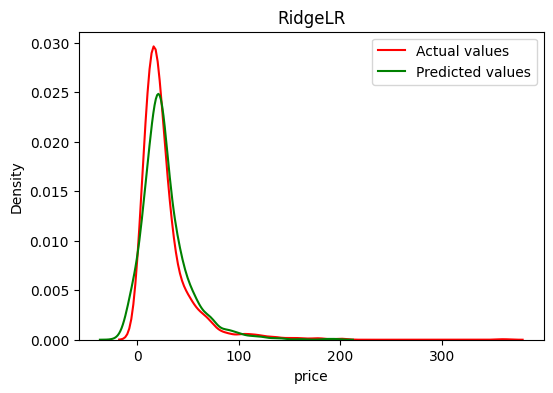

In [938]:
print_chart("RidgeLR", Y_test,Y_pred)

##### Подбор оптимальных параметров

In [939]:
model = Ridge()
gridSearchCV_params(model, parameters, X_train,Y_train)
randomizedSearchCV_params(model, parameters, X_train,Y_train)

 Лучшие параметры для модели (GridSearchCV) 'alpha':0.11
Лучшие параметры для модели (RandomizedSearchCV) 'alpha':0.11


In [940]:
ridge = Ridge(alpha=0.21).fit(X_train,Y_train)
Y_pred = ridge.predict(X_test)

print_error(Y_test, Y_pred)

               Метрики качества
MAE                     8.87974
MSE                   222.26112
RMSE                   14.90842
MAPE                    0.50174
Adjusted_rand          -0.00002
R^2                     0.68483


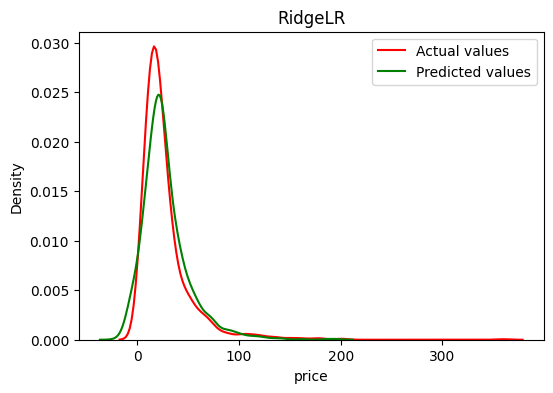

In [941]:
print_chart("RidgeLR", Y_test,Y_pred)

In [942]:
def objective(trial):
    # Определяем гиперпараметры
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    model = Ridge(alpha=alpha)

    # Обучаем модель
    model.fit(X_train, Y_train)

    # Предсказываем
    y_pred = model.predict(X_test)

    # Вычисляем ошибки
    mse = mean_squared_error(Y_test, y_pred)
    return mse 

In [943]:
best_params = optuna_params(objective)
best_model = Lasso(alpha=best_params['alpha'])
best_model.fit(X_train,Y_train)
Y_pred = best_model.predict(X_test)

print_error(Y_test,Y_pred)

               Метрики качества
MAE                    11.18320
MSE                   324.43405
RMSE                   18.01205
MAPE                    0.65287
Adjusted_rand           0.00539
R^2                     0.53995


#### <span style = "color: #D47979">Линейная регрессия с двумя регуляризаторами

- Для данной реализации воспользуемся моделью линейной регрессии _Elastic Net_, которая объединяет L1 _(Lasso)_ и L2 _(Ridge)_ регуляризации.
- У неё есть параметр ```l1_ratio```, который определяет, насколько сильна L1 регуляризация по сравнению с L2.


In [944]:
from sklearn.linear_model import ElasticNet
l1_ratio = 0.5
elastic_net = ElasticNet(alpha=0.2, l1_ratio=l1_ratio).fit(X_train, Y_train)
Y_pred  = elastic_net.predict(X_test)

In [945]:
elastic_net.coef_

array([ 0.02523775, -7.37602893, -1.37540219,  1.44439443,  6.33168444,
       -0.36743439,  0.16032933, -0.37946285, -0.37411824, -0.97167979,
       -1.77237862])

##### Метрики модели регрессии с двумя регуляризаторами

In [946]:
print_error(Y_test, Y_pred)

               Метрики качества
MAE                    10.35762
MSE                   290.41165
RMSE                   17.04147
MAPE                    0.57171
Adjusted_rand          -0.00002
R^2                     0.58820


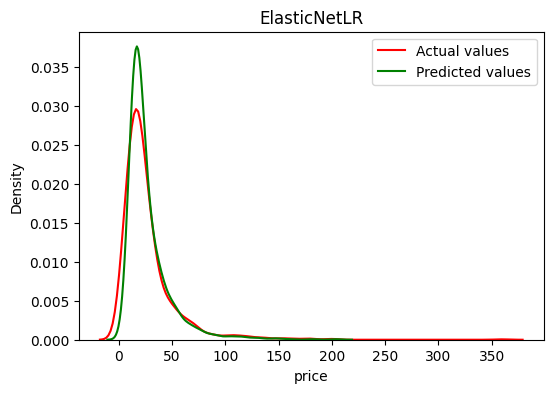

In [947]:
print_chart("ElasticNetLR", Y_test,Y_pred)

##### Подбор оптимальных параметров

In [948]:
parameters = {'alpha': np.arange(0.01,1,0.1), 
              'l1_ratio': np.arange(0.01,1,0.1)}
gridSearchCV_params(ElasticNet(), parameters, X_train,Y_train)
randomizedSearchCV_params(ElasticNet(), parameters, X_train, Y_train)

 Лучшие параметры для модели (GridSearchCV) 'alpha':0.01, 'l1_ratio':0.91
Лучшие параметры для модели (RandomizedSearchCV) 'l1_ratio':0.61, 'alpha':0.11


In [949]:
l1_ratio = 0.91
elastic_net = ElasticNet(alpha=0.01, l1_ratio=l1_ratio).fit(X_train, Y_train)
Y_pred  = elastic_net.predict(X_test)

In [950]:
print_error(Y_test, Y_pred)

               Метрики качества
MAE                     8.69916
MSE                   221.79177
RMSE                   14.89268
MAPE                    0.46608
Adjusted_rand          -0.00002
R^2                     0.68550


In [951]:
print_error(Y_test,Y_pred, custom=True)

               Метрики качества
MAE                     8.69916
MSE                   221.79177
RMSE                   14.89268
MAPE                    0.68270
Adjusted_rand          -0.00002
R^2                     0.68550


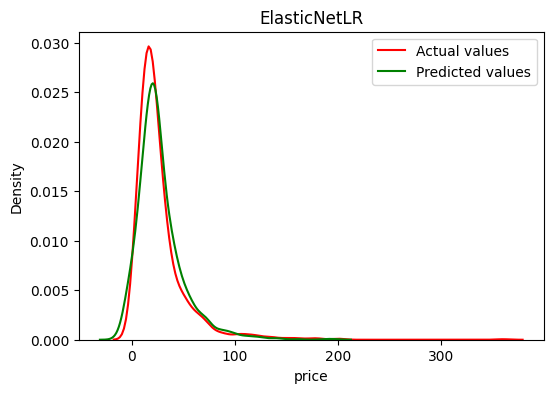

In [952]:
print_chart("ElasticNetLR", Y_test,Y_pred)

In [953]:
def objective(trial):
    # Определяем гиперпараметры
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e2)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

    # Обучаем модель
    model.fit(X_train, Y_train)

    # Предсказываем
    y_pred = model.predict(X_test)

    # Вычисляем ошибки
    mse = mean_squared_error(Y_test, y_pred)
    return mse 

In [954]:
best_params = optuna_params(objective)
best_model = ElasticNet(alpha=best_params['alpha'],l1_ratio=best_params['l1_ratio'] )
best_model.fit(X_train,Y_train)
Y_pred = best_model.predict(X_test)

print_error(Y_test,Y_pred)

               Метрики качества
MAE                     8.72236
MSE                   221.64110
RMSE                   14.88762
MAPE                    0.47181
Adjusted_rand          -0.00002
R^2                     0.68571


#### <span style = "color: #5A7CEB">Полиномиальная регрессия

In [955]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [956]:
Input = [('standardscaler', StandardScaler()), ('polynomial', PolynomialFeatures(degree=3, include_bias=False)), ('model', LinearRegression()) ]

pipe = Pipeline(Input)
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomial',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('model', LinearRegression())])

In [957]:
pipe.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('polynomial',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('model', LinearRegression())])

In [958]:
Y_pred_pipe = pipe.predict(X_test)

##### Метрики модели

In [959]:
print_error(Y_pred_pipe, Y_test)

               Метрики качества
MAE                     7.59990
MSE                   195.02904
RMSE                   13.96528
MAPE                    0.42149
Adjusted_rand          -0.00002
R^2                     0.68409


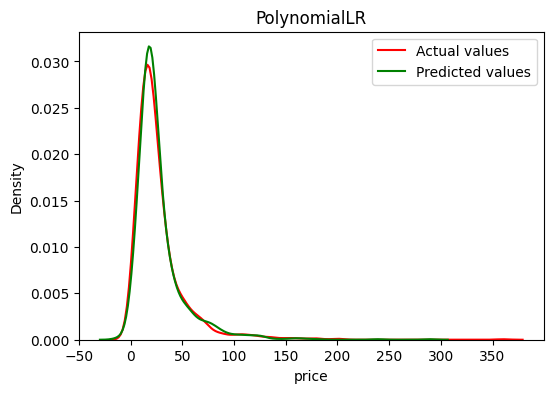

In [960]:
print_chart("PolynomialLR", Y_test,Y_pred_pipe)

#### Вывод

Значения при некоторых предикторах практически 0. Это свидетельствует о незначимости данных предикторов.

#### <snap style = "color: #48B0AB">Реализация линейного регрессора

**Реализация стандартизатора**

**Градиентный спуск** — это итеративный алгоритм оптимизации, используемый для нахождения минимума функции. В контексте машинного обучения он применяется для минимизации функции стоимости (loss function), которая измеряет ошибку модели.

**Шаг 1: ИНИЦИАЛИЗАЦИЯ ПАРАМЕТРОВ** 
- Инициализируем параметры $\theta$ случайными малыми значениями

$$\theta = [\theta_0, \theta_1, \dots, \theta_n] $$

${\theta_0 (b)}$ - независимая переменная, отвечает за перехват, ${\theta_1, \dots, \theta_n}$ - коэффициенты при признаках


**Шаг 2: ВЫЧИСЛЕНИЕ ФУНКЦИИ ПОТЕРЬ**

**Функция потерь в линейной регрессии с L2-регуляризацией**

$$J(\theta) = \frac{1}{m} \sum_{i=1}^m (h_\theta(x_i) - y_i)^2 + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$$

- ${m}$ - число наблюдений
- $\frac{1}{m} \sum_{i=1}^m (h_\theta(x_i) - y_i)^2$ - MSE (Среднеквадратичная ошибка )
- $\lambda$ - коэффициент регуляризации
- $\frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$ - **L2-регуляризация** 



**Шаг 3: ВЫЧИСЛЕНИЕ ГРАДИЕНТОВ**

- Градиент MSE (в матричной форме): 
$$\frac{\partial J_{\text{MSE}}}{\partial \theta} = \frac{2}{m} X^T (h_\theta(X) - y)$$

- Градиент L2-регуляризации
$$\frac{2\lambda}{m} \theta_j \quad (j \geq 1)$$

- Полный градиент
$$\nabla J(\theta) = \frac{2}{m} X^T (h_\theta(X) - y) + \frac{\lambda}{m} \begin{bmatrix} 0 \\ \theta_1 \\ \theta_2 \\ \vdots \\ \theta_n \end{bmatrix}$$

**Шаг 4: ОБНОВЛЕНИЕ ПАРАМЕТРОВ**

Обновляем параметры ${\theta}$ в направлении, противоположном градиенту:
$$\theta := \theta - \alpha \cdot \nabla J(\theta)$$

**Шаг 5: ПРОВЕРКА СХОДИМОСТИ**

- Вычисляем новую функцию стоимости после обновления $\theta$
- Если изменение функции стоимости меньше порога ```eps```, то останавливаем обучение
$$|\text{cost}_{\text{prev}} - \text{cost}_{\text{current}}| < {\epsilon}$$
- Иначе повторяем шаги 2-4 до максимального числа итераций ```iterations```

In [961]:
class GradientDescentLinearRegression:
    def __init__(self, alpha=0.01, iterations=2000, l2_lambda=0.3, eps=1e-7):
        self.alpha = alpha
        self.iterations = iterations
        self.l2_lambda = l2_lambda
        self.eps = eps
        self.theta = None
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.cost_history = []

    def _add_intercept(self, X):
        return np.c_[np.ones(X.shape[0]), X]

    def _compute_cost(self, X, y, theta):
        m = len(y)
        predictions = X.dot(theta)
        errors = predictions - y
        cost = (1/(m)) * np.sum(errors**2) + (self.l2_lambda/(2*m)) * np.sum(theta[1:]**2)
        return cost

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).ravel()

        X_scaled = self.scaler_X.fit_transform(X)
        y_scaled = self.scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

        X_b = self._add_intercept(X_scaled)
        m, n = X_b.shape
        self.theta = np.random.randn(n)
        self.cost_history = []

        for iteration in range(self.iterations):
            predictions = X_b.dot(self.theta)
            
            errors = predictions - y_scaled
            gradients = (2/m) * X_b.T.dot(errors)  
           
            regularization_term = (self.l2_lambda/m) * self.theta
            regularization_term[0] = 0
            gradients += regularization_term

            self.theta = self.theta - self.alpha * gradients

            cost = self._compute_cost(X_b, y_scaled, self.theta)
            self.cost_history.append(cost)

          
            if iteration > 0 and abs(self.cost_history[-2] - cost) < self.eps:
                break

    def predict(self, X):
        X = np.array(X)
        X_scaled = self.scaler_X.transform(X)
        X_b = self._add_intercept(X_scaled)
        y_scaled_pred = X_b.dot(self.theta)
        return self.scaler_y.inverse_transform(y_scaled_pred.reshape(-1, 1)).ravel()

In [962]:
cLR = GradientDescentLinearRegression(alpha=0.01,iterations=2000, l2_lambda=0.3)

cLR.fit(X_train, Y_train)

Y_pred = cLR.predict(X_test)

print_error(Y_test, Y_pred)



               Метрики качества
MAE                     8.89198
MSE                   222.20630
RMSE                   14.90659
MAPE                    0.50353
Adjusted_rand          -0.00002
R^2                     0.68491


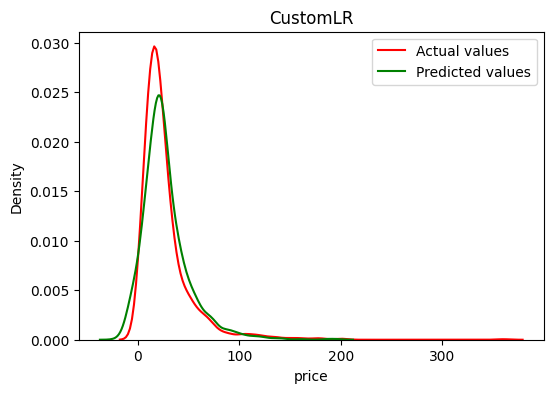

In [963]:
print_chart('CustomLR', Y_test, Y_pred)

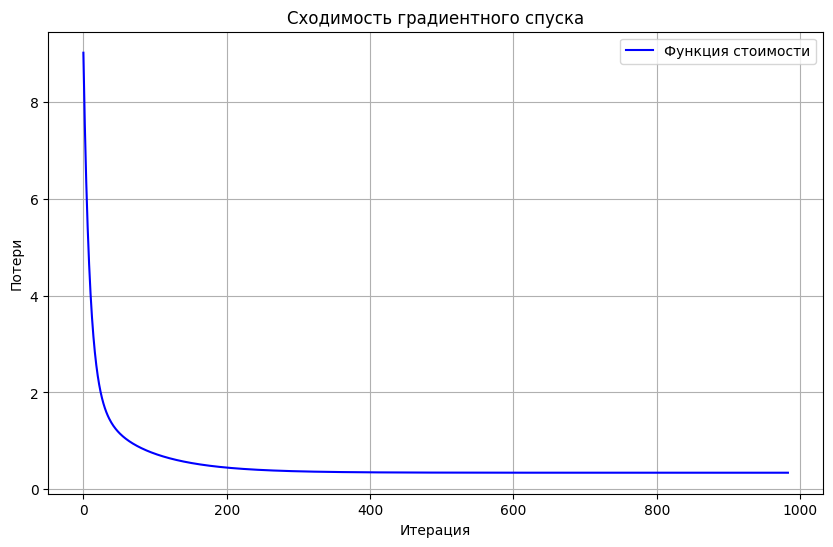

In [964]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10, 6))
plt.plot(range(len(cLR.cost_history)), cLR.cost_history, 'b-', label='Функция стоимости')
plt.xlabel('Итерация')
plt.ylabel('Потери')
plt.title('Сходимость градиентного спуска')
plt.grid(True)
plt.legend()
plt.show()